In [1]:
import pandas as pd
import pickle
import numpy as np
from datetime import datetime, timedelta
from EM import EM
import matplotlib.pyplot as plt
from plot import plot

In [2]:
data = np.load('../Data/test_preprocessed_data.npz')

In [3]:
# EM Setting
training_pct = .8
single_effect = False
num_past_effects = 2

In [9]:
em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
            X_prev = data['X_prev_mtx'], single_effect=single_effect)
em.run_EM(10)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
7 iterations before loglik converges


7

In [10]:
all([em.obs_log_lik[j] <= em.obs_log_lik[j+1] for j in range(len(em.obs_log_lik)-1)])

True

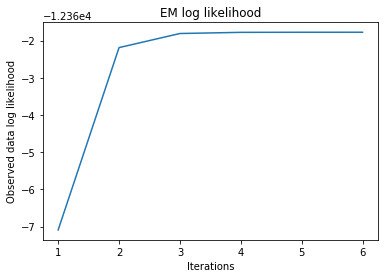

In [11]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [7]:
hah

NameError: name 'hah' is not defined

In [ ]:
cdm_t = pd.read_pickle('../Data/cdm_t.pkl')
cdm_s = pd.read_pickle('../Data/cdm_s.pkl')

In [ ]:
signal_context = {}

In [ ]:
signal_name = 'platelets'
treatment_names = {}
treatment_names['platelets_transfusion'] = ['transfuse_platelets']
treatment_names['ditp'] = ['ibuprofen_dose',
 'acetaminophen_dose',
 'ampicillin_dose',
 'heparin_dose',
 'vancomycin_dose',
 'piperacillin_tazobac_dose',
 'naproxen_dose']

chronic_keywords = ['liver', 'sickle_cell']
demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [ ]:
signal_name = 'creatinine'

treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['nephrotoxic_drugs'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['dronedarone'] = ['dronedarone_dose']
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['ace_i'] = ['lisinopril_dose',
 'ramipril_dose',
 'benazepril_dose',
 'enalaprilat_dose',
 'captopril_dose',
 'perindopril_dose',
 'trandolapril_dose']
treatment_names['arb'] = ['valsartan_dose',
 'telmisartan_dose',
 'irbesartan_dose',
 'losartan_dose',
 'candesartan_dose']

#treatment_names['search'] = ['losartan']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'sickle_cell']

demographic_names = ['gender', 'admit_weight']
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [ ]:
signal_name = 'creatinine'
treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]

In [ ]:
# chronic_names: 
# key: keywords of the relevant chronic conditions specified in chronic_keywords
# value: list of all the features in cdm_s that contain that keyword
# fill in chronic name dict by finding all the relevant fields available in cdm_s for each chronic keyword
chronic_names = {}
all_chronic = cdm_s.loc[:, 'fid'].unique()
for name in chronic_keywords:
    chronic_names[name] = [s for s in all_chronic if name in s]

In [ ]:
# put all the treatment names into a list to get the corresponding columns
treatment_list = []
for name in treatment_names.values():
    treatment_list.append(name)
# flatten the list
treatment_list = [item for sublist in treatment_list for item in sublist]

In [ ]:
# df_t is part of the original dataframe that has all the ids who have measurements for the signal we are interested 
# in
signal = cdm_t.loc[cdm_t.loc[:, 'fid'] == signal_name, 'value']
ids = np.unique(cdm_t.loc[signal.index, 'enc_id'])
df_t = cdm_t.loc[cdm_t.loc[:, 'enc_id'].isin(ids), :]

In [ ]:
# df_t is now part of the dataframe that contains only the rows with fid being either the signal or the treatments
df_t = df_t.loc[df_t.loc[:, 'fid'].isin(treatment_list + [signal_name]), :]

In [ ]:
# convert tsp field to python datetime object
df_t.loc[:, 'tsp'] = df_t.loc[:, 'tsp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+%f'))
#df_t.loc[:, 'tsp'] = df_t.groupby('enc_id')['tsp'].apply(lambda x: x - x.iloc[0])

In [ ]:
df_t = df_t.loc[df_t.loc[:, 'fid'].isin(['transfuse_platelets', 'platelets']), :]

In [ ]:
ids = np.unique(df_t.loc[df_t['fid']=='transfuse_platelets', 'enc_id'])
df_t = df_t.loc[df_t['enc_id'].isin(ids), :]

In [ ]:
index_after_binned = np.array([ 9019, 14243, 21493, 21810, 22846, 24172, 26041, 26535, 39820,
       39880, 40278, 41259, 41391, 41580, 45535, 46232, 47871, 48933,
       52675, 56764, 61342, 61734, 62080, 63689, 65467, 65948, 72028,
       72107, 73527, 75414, 75484, 77601, 79029, 80172, 88435, 88566,
       89834, 98771])
df_t = df_t.loc[df_t['enc_id'].isin(index_after_binned)]

In [ ]:
df_t

In [ ]:
def plot_group(gp):
    print(gp['enc_id'].iloc[0])
    obs = gp.loc[gp['fid']=='platelets', 'value']
    obs_time = gp.loc[obs.index, 'tsp'].values
    treat_time = gp.loc[gp['fid']=='transfuse_platelets', 'tsp'].values
    obs = obs.apply(lambda x: float(x)).values
    fig = plt.figure()
    plt.plot(obs_time, obs, '.')
    for t in treat_time:
        plt.axvline(x=t, linestyle=':')
    fig.set_figheight(6)
    fig.set_figwidth(10)
    plt.show()

In [ ]:
gp = df_t.groupby('enc_id').apply(lambda x: plot_group(x))